<a href="https://colab.research.google.com/github/NINAD-ML/PRODIGY_ML_03/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset downloaded to: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1
Zip file not found; assuming dataset is already extracted.
Using images from: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages
Processing 5000 images from /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat...


Loading Cat images: 100%|██████████| 5000/5000 [00:14<00:00, 351.16it/s]


Processing 5000 images from /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog...


Loading Dog images: 100%|██████████| 5000/5000 [00:08<00:00, 603.72it/s]


Total images loaded: 9977
Training samples: 7981
Testing samples: 1996
Training SVM model...
Test Accuracy: 0.5251
              precision    recall  f1-score   support

         Cat       0.53      0.57      0.55      1014
         Dog       0.52      0.48      0.50       982

    accuracy                           0.53      1996
   macro avg       0.52      0.52      0.52      1996
weighted avg       0.52      0.53      0.52      1996



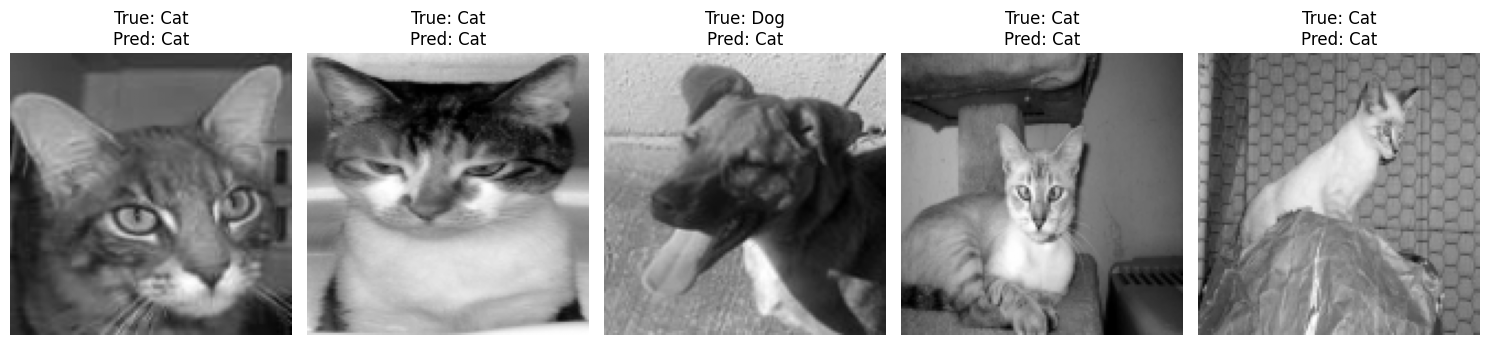

In [2]:
# Install necessary packages
!pip install kagglehub opencv-python-headless numpy scikit-learn matplotlib tqdm

# Import libraries
import kagglehub
import os
import zipfile
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Download dataset
print("Downloading dataset...")
dataset_path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")
print("Dataset downloaded to:", dataset_path)

# Unzip dataset
zip_filename = os.path.join(dataset_path, "microsoft-catsvsdogs-dataset.zip")
if os.path.exists(zip_filename):
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    print("Dataset unzipped.")
else:
    print("Zip file not found; assuming dataset is already extracted.")

# Set images folder path
images_folder = os.path.join(dataset_path, "PetImages")
if not os.path.exists(images_folder):
    raise Exception("PetImages folder not found. Check dataset structure.")
print("Using images from:", images_folder)

# Define constants
IMG_SIZE = 128  # Increased resolution
MAX_IMAGES_PER_CLASS = 5000  # Increased image count

data = []
labels = []

# Load images
def load_images(label):
    folder_path = os.path.join(images_folder, label)
    if not os.path.exists(folder_path):
        print(f"Warning: {folder_path} does not exist.")
        return []

    valid_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    valid_files = random.sample(valid_files, min(len(valid_files), MAX_IMAGES_PER_CLASS))

    print(f"Processing {len(valid_files)} images from {folder_path}...")

    images, image_labels = [], []
    for filename in tqdm(valid_files, desc=f"Loading {label} images"):
        filepath = os.path.join(folder_path, filename)
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
        images.append(img.flatten())
        image_labels.append(label)

    return images, image_labels

# Load Cats and Dogs images
cat_images, cat_labels = load_images("Cat")
dog_images, dog_labels = load_images("Dog")

data = np.array(cat_images + dog_images, dtype=np.float32) / 255.0
labels = np.array(cat_labels + dog_labels)
print("Total images loaded:", len(data))

# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

if len(data) == 0:
    raise ValueError("No images loaded. Check dataset path and file formats.")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

# Train SVM model
print("Training SVM model...")
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Evaluate model
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.4f}".format(accuracy))
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Visualize predictions
sample_files = random.sample(list(zip(data, labels_encoded)), 5)
plt.figure(figsize=(15, 8))
for i, (img_flat, true_label) in enumerate(sample_files):
    img_resized = img_flat.reshape(IMG_SIZE, IMG_SIZE)
    pred_label = svm_model.predict([img_flat])[0]
    pred_label = encoder.inverse_transform([pred_label])[0]
    true_label = encoder.inverse_transform([true_label])[0]

    plt.subplot(1, 5, i+1)
    plt.imshow(img_resized, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()